In [9]:
# VGG16 합성곱 기반 층 만들기
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', #모델 초기화할 가중치 체크포인트 지정
                 include_top= False, # 최상위 완전연결분류기 포함 여부
                 input_shape=(150, 150, 3)) # 네트워크에 주입할 이미지 텐서 크기

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [10]:
# 1. 새로운 데이터셋에서 합성곱 기반 층 실행 후 출력을 numpy 배열로 디스크에 저장 -> 독립된 완전 연결 분류기에 입력
# 빠르고 비용 적음 / 데이터 증식 사용 불가

# 사전 훈련된 합성곱 기반 층을 사용한 특성 추출: ImageDataGenerator를 사용해 이미지와 레이블을 넘파이 배열로 추출
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '../datasets/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) # conv_base 모델의 predict 메소드 호출해 이미지의 특성 추출
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.


2022-03-22 13:34:14.099112: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-22 13:34:14.151841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
# 추출된 특성의 크기: (samples, 4, 4, 512)
# 완전 연결 분류기에 주입하기 위해 (samples, 8192) 크기로 펼치기
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [13]:
# 완전 연결 분류기를 정의하고 저장된 데이터와 레이블을 사용해 훈련
from keras import models
from keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5)) # 드롭아웃 사용
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy', # Dog vs Cat -> 이진분류
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30


/Users/youngeun/miniforge3/envs/venv/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


  1/100 [..............................] - ETA: 31s - loss: 0.8680 - acc: 0.4000

2022-03-22 13:41:21.368798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 1s 12ms/step - loss: 0.5678 - acc: 0.7050 - val_loss: 0.4615 - val_acc: 0.8250
Epoch 2/30
  1/100 [..............................] - ETA: 0s - loss: 0.5323 - acc: 0.7000

2022-03-22 13:41:22.528837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 1s 9ms/step - loss: 0.4009 - acc: 0.8340 - val_loss: 0.3684 - val_acc: 0.8630
Epoch 3/30
100/100 [==============================] - 1s 9ms/step - loss: 0.3326 - acc: 0.8745 - val_loss: 0.3249 - val_acc: 0.8810
Epoch 4/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2922 - acc: 0.8875 - val_loss: 0.2996 - val_acc: 0.8890
Epoch 5/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2681 - acc: 0.9020 - val_loss: 0.2928 - val_acc: 0.8840
Epoch 6/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2404 - acc: 0.9180 - val_loss: 0.2720 - val_acc: 0.8940
Epoch 7/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2314 - acc: 0.9155 - val_loss: 0.2660 - val_acc: 0.8970
Epoch 8/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2134 - acc: 0.9225 - val_loss: 0.2712 - val_acc: 0.8860
Epoch 9/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2007 - acc:

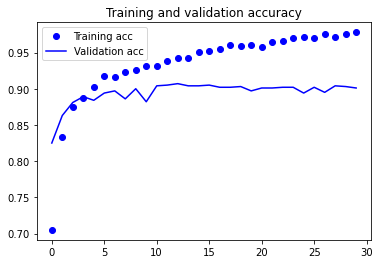

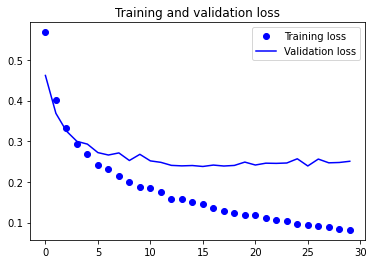

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()